## Probabilistic Boosting 

For probabilistic boosting we use the ngboost package.

- Documentation https://docs.google.com/presentation/d/1Tn23Su0ygR6z11jy3xVNiLGv0ggiUQue/edit?slide=id.p1#slide=id.p1
- Paper https://arxiv.org/abs/1910.03225
- Documentation https://stanfordmlgroup.github.io/ngboost/intro.html

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
plt.style.use('default')

In [2]:
#!pip install --upgrade ngboost

## Demo 1-D Regression

We demonstrate the use of ngboost for 1-D regression with non-constant variance (heteroscedasticity).

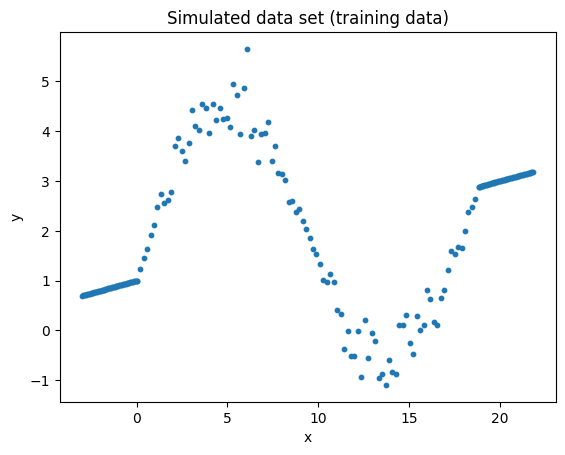

In [3]:
def dgp_2(n):
    np.random.seed(32)
    x = np.linspace(0,1*2*np.pi,n)
    y1 = 3*np.sin(x)
    y1 = np.concatenate((np.zeros(60), y1+np.random.normal(0,0.15*np.abs(y1),n),np.zeros(60)))
    x=np.concatenate((np.linspace(-3,0,60),np.linspace(0,3*2*np.pi,n),np.linspace(3*2*np.pi,3*2*np.pi+3,60)))
    y2 = 0.1*x+1
    y=y1+y2
    return x.reshape(-1,1),y.reshape(-1,1)

dgp = dgp_2

x_train, y_train = dgp(100)
x_val, y_val = dgp(1000)    #We can afford a larger validation set here since the data is simulated
plt.scatter(x_train, y_train, s=10)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Simulated data set (training data)')
plt.show()

In [4]:
from ngboost import NGBRegressor
from ngboost.distns import Normal, NormalFixedVar # NormalFixedVar is with constant variance
ngb = NGBRegressor(Dist=Normal).fit(x_train, y_train.flatten(), 
    X_val=x_val, Y_val=y_val.flatten(), early_stopping_rounds=2)

[iter 0] loss=1.7871 val_loss=1.9602 scale=1.0000 norm=1.3748
[iter 100] loss=0.8822 val_loss=1.0353 scale=2.0000 norm=1.1738
[iter 200] loss=-0.0348 val_loss=0.3559 scale=2.0000 norm=0.9988
== Early stopping achieved.
== Best iteration / VAL245 (val_loss=0.2414)


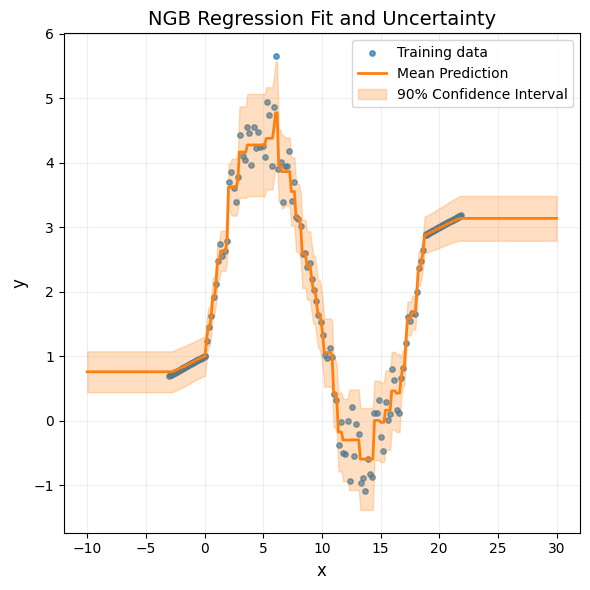

In [5]:
## Nicer plot with shaded confidence interval area between 5th and 95th percentiles
x_test = np.linspace(-10, 30, 300).reshape(-1, 1)
dist = ngb.pred_dist(x_test)

mus = dist.params['loc']
sigmas = dist.params['scale']

# Calculate percentiles for the confidence interval
lower = dist.dist.ppf(0.05)
upper = dist.dist.ppf(0.95)

plt.figure(figsize=(6,6))
plt.scatter(x_train, y_train, s=15, color='tab:blue', label='Training data', alpha=0.7)
plt.plot(x_test, mus, color='tab:orange', lw=2, label='Mean Prediction')
plt.fill_between(x_test.ravel(), lower, upper, color='tab:orange', alpha=0.25, label='90% Confidence Interval')

plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('NGB Regression Fit and Uncertainty', fontsize=14)
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

### 2 Class Classification


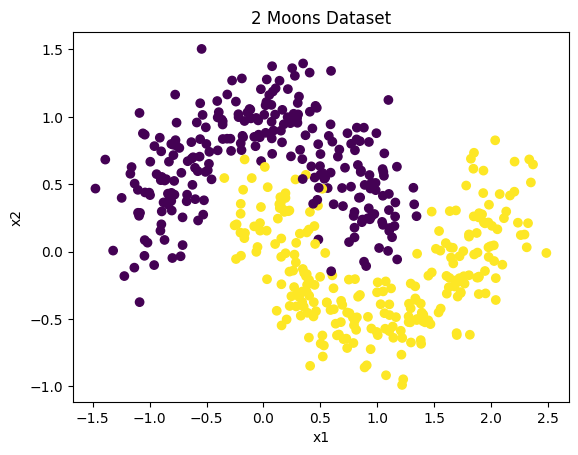

In [6]:
## Create the 2 moons dataset

from sklearn.datasets import make_moons
x_train, y_train = make_moons(n_samples=500, noise=0.2, random_state=42)

# Plot the dataset
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, cmap=plt.cm.viridis)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('2 Moons Dataset')
plt.show()

In [7]:
### Fitting a NGBClassifier

from ngboost import NGBClassifier
from ngboost.distns import Bernoulli

ngb_clf = NGBClassifier(Dist=Bernoulli, n_estimators=1000, learning_rate=0.01).fit(x_train, y_train)

[iter 0] loss=0.6931 val_loss=0.0000 scale=4.0000 norm=8.0000
[iter 100] loss=0.1366 val_loss=0.0000 scale=2.0000 norm=2.4314
[iter 200] loss=0.1101 val_loss=0.0000 scale=1.0000 norm=1.1805
[iter 300] loss=0.1058 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 400] loss=0.1058 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 500] loss=0.1058 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 600] loss=0.1058 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 700] loss=0.1058 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 800] loss=0.1058 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 900] loss=0.1058 val_loss=0.0000 scale=0.0001 norm=0.0001


/var/folders/bk/0vv7sh9n43n3dm4fth1qw93r0000gq/T/ipykernel_2686/229904686.py:29: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X1, X2, proba_grid, levels=[0.5], colors='black',


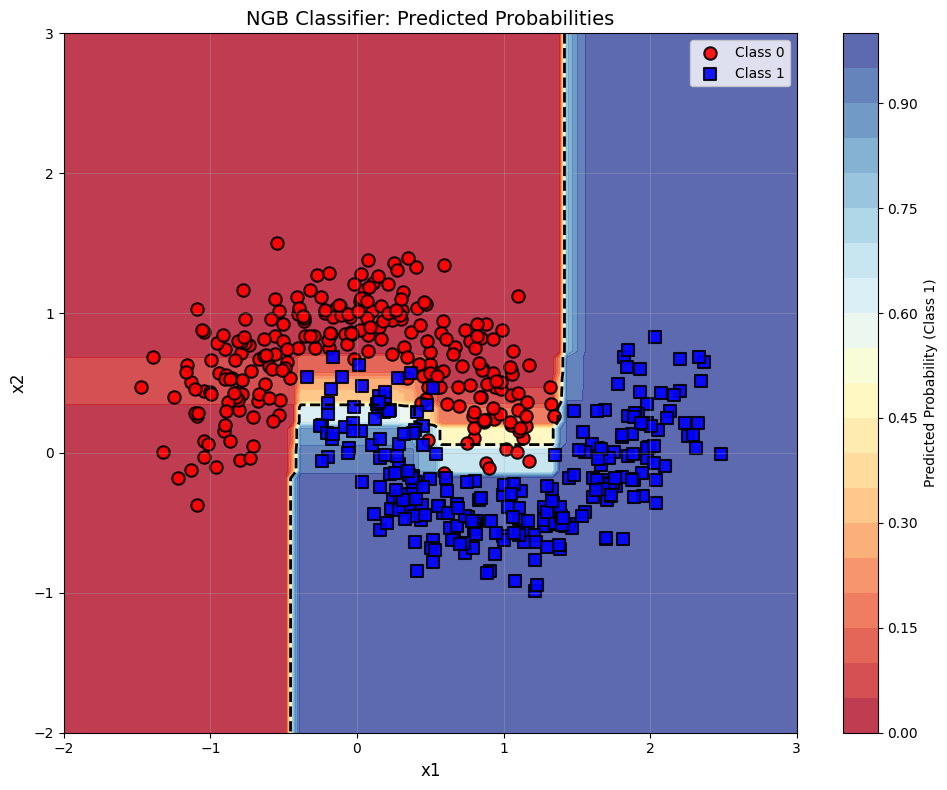

In [8]:
# Plot the predicted probabilities in the range for x1 and x2
x1_range = np.linspace(-2, 3, 100)
x2_range = np.linspace(-2, 3, 100)

# Create meshgrid
X1, X2 = np.meshgrid(x1_range, x2_range)
X_grid = np.c_[X1.ravel(), X2.ravel()]

# Get predicted probabilities for class 1
proba = ngb_clf.predict_proba(X_grid)[:, 1]
proba_grid = proba.reshape(X1.shape)

# Plot
plt.figure(figsize=(10, 8))
contour = plt.contourf(X1, X2, proba_grid, levels=20, cmap='RdYlBu', alpha=0.8)
plt.colorbar(contour, label='Predicted Probability (Class 1)')

# Overlay training data with different markers for each class
for class_label in [0, 1]:
    mask = y_train == class_label
    color = 'red' if class_label == 0 else 'blue'
    marker = 'o' if class_label == 0 else 's'
    plt.scatter(x_train[mask, 0], x_train[mask, 1], 
               c=color, marker=marker,
               edgecolors='black', linewidths=1.5, 
               s=80, label=f'Class {class_label}', alpha=0.9)

# Add decision boundary (where probability = 0.5)
plt.contour(X1, X2, proba_grid, levels=[0.5], colors='black', 
           linewidths=2, linestyles='--', label='Decision Boundary (p=0.5)')

plt.xlabel('x1', fontsize=12)
plt.ylabel('x2', fontsize=12)
plt.title('NGB Classifier: Predicted Probabilities', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Example for 3 classes

In [9]:
# Use the Iris dataset
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from ngboost import NGBClassifier, distns

iris = load_iris()
x_all, y_all = iris.data, iris.target

# Split into 80% training and 20% validation
x_train, x_val, y_train, y_val = train_test_split(
    x_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

# Fit a NGBClassifier with validation set
# We use only 2 trees (otherwise performance is too good)
ngb_clf = NGBClassifier(Dist=distns.k_categorical(3), n_estimators=2, learning_rate=0.01).fit(
    x_train, y_train
)
np.round(ngb_clf.predict_proba(x_val[0:5]),3)

[iter 0] loss=1.0986 val_loss=0.0000 scale=32.0000 norm=109.2548


array([[0.697, 0.152, 0.152],
       [0.153, 0.153, 0.694],
       [0.152, 0.697, 0.152],
       [0.152, 0.697, 0.152],
       [0.697, 0.152, 0.152]])

In [10]:
import numpy as np
np.round(ngb_clf.predict_proba(x_val[0:5]),3)

array([[0.697, 0.152, 0.152],
       [0.153, 0.153, 0.694],
       [0.152, 0.697, 0.152],
       [0.152, 0.697, 0.152],
       [0.697, 0.152, 0.152]])

# Outlook Deep Learning


For using TapFFN you need an access token from Hugging-Face (Mid Nov 2025). The setting must allow fined-grained access.
https://huggingface.co/settings/tokens
Store that token in `~/.zshrc` with name `export HF_TOKEN=...` 

In [31]:
from tabpfn import TabPFNRegressor
reg = TabPFNRegressor()
x_train, y_train = dgp(100)
x_val = np.linspace(-10, 30, 300).reshape(-1, 1)
reg.fit(x_train, y_train)
#preds = reg.predict(x_val, output_type="full")
quantile_predictions = reg.predict(x_val, output_type='quantiles', quantiles=[0.05, 0.5, 0.95])

/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


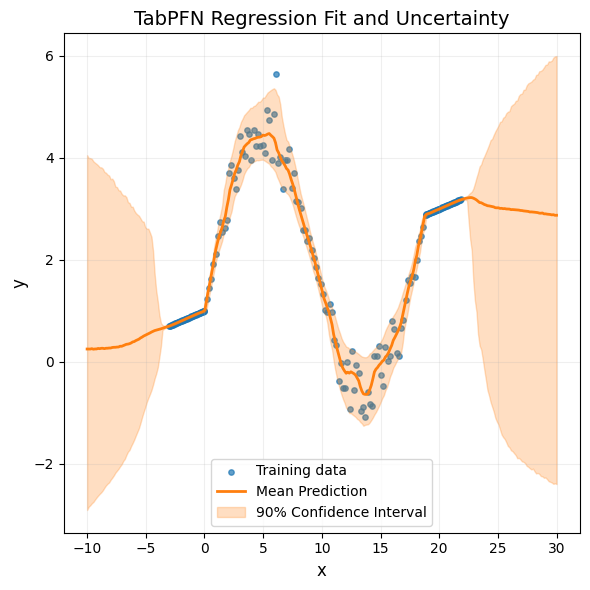

In [32]:
lower = quantile_predictions[0]  # 0.05 quantile
mus = quantile_predictions[1]     # 0.5 quantile (median/mean)
upper = quantile_predictions[2]  # 0.95 quantile

plt.figure(figsize=(6,6))
plt.scatter(x_train, y_train, s=15, color='tab:blue', label='Training data', alpha=0.7)
plt.plot(x_val, mus, color='tab:orange', lw=2, label='Mean Prediction')
plt.fill_between(x_val.ravel(), lower, upper, color='tab:orange', alpha=0.25, label='90% Confidence Interval')

plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('TabPFN Regression Fit and Uncertainty', fontsize=14)
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()